In [1]:
DATE = "2021-09-20"
TASK = "random-drop-resampling"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-09-20-random-drop-resampling"

In [2]:
import Pkg
pkgs = [
    "BioAlignments",
    "BioSequences",
    "Clustering",
    "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "Distributions",
#     "EzXML",
    "FASTX",
#     "GFF3",
    "GLM",
    "GraphPlot",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LsqFit",
#     "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
    "OnlineStats",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
function kmer_index_and_orientation_to_kmer(graph, kmer_index, orientation)
    kmer = graph.vprops[kmer_index][:kmer]
    if !orientation
        kmer = BioSequences.reverse_complement(kmer)
    end
    return kmer
end

kmer_index_and_orientation_to_kmer (generic function with 1 method)

In [4]:
function determine_edge_probabilities(graph)
    nv = LightGraphs.nv(graph)
    edge_probabilities = SparseArrays.spzeros(nv, nv)
    for v in 1:nv
        neighbors = LightGraphs.neighbors(graph, v)
        @assert issorted(neighbors)
        likelihoods = zeros(length(neighbors))
        for (i, neighbor) in enumerate(neighbors)
            if v <= neighbor
                edge = LightGraphs.Edge(v, neighbor)
            else
                edge = LightGraphs.Edge(neighbor, v)
            end
            @assert LightGraphs.has_edge(graph, edge)
            likelihoods[i] = graph.eprops[edge][:count]     
        end
        likelihoods = likelihoods ./ sum(likelihoods)
#         @show likelihoods
#         @show neighbors
        for (neighbor, likelihood) in zip(neighbors, likelihoods)
            edge_probabilities[v, neighbor] = likelihood
        end
    end
    
    for source in 1:size(edge_probabilities, 1)
        destinations = findall(edge_probabilities[source, :] .> 0)
        destination_counts = [graph.vprops[dest][:count] for dest in destinations]
        destination_likelihoods = destination_counts ./ sum(destination_counts)
        for (dest, likelihood) in zip(destinations, destination_likelihoods)
            edge_probabilities[source, dest] *= likelihood
        end
        edge_probabilities[source, :] ./= sum(edge_probabilities[source, :])
        @assert abs(1-sum(edge_probabilities[source, :])) <= eps(Float64)
    end
    
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [5]:
function orient_path(graph, kmers, path, opening_orientation, opening_kmer, closing_orientation)
    vertices = path
    path_orientations = [opening_orientation]
    path_kmers = [opening_kmer]
    @show opening_orientation
    for (i, vertex) in enumerate(vertices[2:end])
        @show i, vertex, last(path_orientations)
        viable_neighbors = typeof(opening_kmer)[]
        viable_neighbor = nothing
        viable_orientations = Bool[]
        viable_orientation = nothing
        for neighbor in BioSequences.neighbors(last(path_kmers))
            @show "considering going from $(last(path_kmers)) to $(neighbor)"
#             @show "considering going from $(last(path_kmers)) to $(neighbor)"
            canonical_neighbor = BioSequences.canonical(neighbor)
            canonical_neighbor_index_range = searchsorted(kmers, canonical_neighbor)
#             @show canonical_neighbor_index_range
            if length(canonical_neighbor_index_range) == 1
                @show canonical_neighbor_index = first(canonical_neighbor_index_range)
                if canonical_neighbor_index == vertex
                    @show "hit, selecting $neighbor"
                    viable_neighbor = neighbor
                    viable_orientation = neighbor == canonical_neighbor
                end
            end
        end
        if (viable_neighbor != nothing) && (viable_orientation != nothing)
            push!(path_kmers, viable_neighbor)
            push!(path_orientations, viable_orientation)
        else
            return nothing
            # not a viable path, need to look towards the next miss
        end
    end
    return vertices, path_orientations, path_kmers
end

orient_path (generic function with 1 method)

In [114]:
# function take_a_walk(graph, edge_likelihoods, kmers, kmer, walk_length)
function take_a_walk(graph, kmers, kmer, walk_length)
    walk = [kmer]
    current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
    @assert length(current_kmer_indices) == 1
    current_kmer_index = first(current_kmer_indices)
    while length(walk) < walk_length
        viable_neighbors = Tuple{Int, Bool}[]
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_is_canonical = neighbor == canonical_neighbor
            neighbor_vertex_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_vertex_range)
                neighbor_vertex = first(neighbor_vertex_range)
                if LightGraphs.has_edge(graph, current_kmer_index, neighbor_vertex)
                    push!(viable_neighbors, (neighbor_vertex, neighbor_is_canonical))
                end
            end
        end
        if isempty(viable_neighbors)
            return walk
        elseif length(viable_neighbors) == 1
            chosen_neighbor = first(viable_neighbors)
        else
            viable_neighbor_indices = first.(viable_neighbors)
            
            step_likelihoods = StatsBase.weights([graph.vprops[v][:count] for v in viable_neighbor_indices])
#             step_likelihoods = StatsBase.weights(edge_likelihoods[current_kmer_index, viable_neighbor_indices])
            chosen_neighbor = StatsBase.sample(viable_neighbors, step_likelihoods)
        end
        kmer = kmer_index_and_orientation_to_kmer(graph, chosen_neighbor...)
        push!(walk, kmer)
        current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
        @assert length(current_kmer_indices) == 1
        current_kmer_index = first(current_kmer_indices)
    end
    return walk
end

take_a_walk (generic function with 2 methods)

In [7]:
"""
    sort_fastq(input_fastq, output_fastq)

This turns a 4-line FASTQ entry into a single tab separated line,
adds a column with the length of each read, passes it to Unix sort,
removes the length column, and converts it back into a FASTQ file.

sorts longest to shortest!!

http://thegenomefactory.blogspot.com/2012/11/sorting-fastq-files-by-sequence-length.html
"""
function sort_fastq(input_fastq, output_fastq="")
    
    if endswith(input_fastq, ".gz")
        p = pipeline(
                `gzip -dc $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`,
                `gzip`
                )
    else
        p = pipeline(
                `cat $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`
                )
    end
    run(pipeline(p, output_fastq))
    return output_fastq
end

sort_fastq

In [8]:
function count_reads(fastq_file)
    @info "determing # of reads in fastq file"
    n_reads = 0
    for record in Mycelia.open_fastx(fastq_file)
        n_reads += 1
    end
    @show n_reads
    return n_reads
end

count_reads (generic function with 1 method)

In [9]:
function determine_read_lengths(fastq_file; total_reads = Inf)
    if total_reads == Inf
        total_reads = count_reads(fastq_file)
    end
    read_lengths = zeros(Int, total_reads)
    @info "determining read lengths"
    p = ProgressMeter.Progress(total_reads, 1)
    for (i, record) in enumerate(Mycelia.open_fastx(fastq_file))
#         push!(read_lengths, length(FASTX.sequence(record)))
        read_lengths[i] = length(FASTX.sequence(record))
        ProgressMeter.next!(p)
    end
    return read_lengths
end

determine_read_lengths (generic function with 1 method)

In [10]:
function max_canonical_kmers(kmer_type)
    k_size = last(kmer_type.parameters)
    # we only consider canonical kmers so cut in 1/2
    max_canonical_kmers = Int(4^k_size / 2)
    return max_canonical_kmers
end

max_canonical_kmers (generic function with 1 method)

In [11]:
function assess_kmer_saturation(fastq_file, kmer_type; kmers_to_assess=Inf, power=10)
    canonical_kmers = Set{kmer_type}()
    
    max_possible_kmers = max_canonical_kmers(kmer_type)
    
    if kmers_to_assess == Inf
        kmers_to_assess = max_possible_kmers
    end
    
    sampling_points = Int[0]
    i = 0
    while power^i <= kmers_to_assess
        push!(sampling_points, power^i)
        i += 1
    end
    
    unique_kmer_counts = zeros(Int, length(sampling_points))
    
    if length(sampling_points) < 3
        @info "increase the # of reads analyzed or decrease the power to acquire more data points"
        return (;sampling_points, unique_kmer_counts)
    end
    
    p = ProgressMeter.Progress(kmers_to_assess, 1)
    
    kmers_assessed = 0
    for record in Mycelia.open_fastx(fastq_file)
        for kmer in BioSequences.each(kmer_type, FASTX.sequence(record))
            unique_kmers_count = length(canonical_kmers)
            if (kmers_assessed == kmers_to_assess) || (unique_kmers_count == max_possible_kmers)
                sampling_points = vcat(filter(s -> s < kmers_assessed, sampling_points), [kmers_assessed])
                unique_kmer_counts = vcat(unique_kmer_counts[1:length(sampling_points)-1], [unique_kmers_count])
                return (
                    sampling_points = sampling_points,
                    unique_kmer_counts = unique_kmer_counts,
                    read_entire_file = false)
            elseif rem(log(power, kmers_assessed), 1) == 0.0
                i = findfirst(sampling_points .== kmers_assessed)
                unique_kmer_counts[i] = unique_kmers_count
                percent_saturation = round(unique_kmers_count/max_possible_kmers, sigdigits=5) * 100
            end
            canonical_kmer = kmer.fw < kmer.bw ? kmer.fw : kmer.bw
            push!(canonical_kmers, canonical_kmer)
            kmers_assessed += 1
            ProgressMeter.next!(p)
        end
    end
    sampling_points = vcat(filter(s -> s < kmers_assessed, sampling_points), [kmers_assessed])
    unique_kmer_counts = vcat(unique_kmer_counts[1:length(sampling_points)-1], [length(canonical_kmers)])
    return (
        sampling_points = sampling_points,
        unique_kmer_counts = unique_kmer_counts,
        read_entire_file = true)
end

assess_kmer_saturation (generic function with 1 method)

In [12]:
function add_edge_to_graph(graph, edge_mer, kmers)
    edge = BioSequences.LongDNASeq(edge_mer.fw)
#     canonical_src = BioSequences.DNAMer{k}(BioSequences.canonical!(edge[1:end-1]))
#     canonical_dst = BioSequences.DNAMer{k}(BioSequences.canonical!(edge[2:end]))

    canonical_src = BioSequences.canonical(BioSequences.DNAMer{k}(edge[1:end-1]))
    
    src_index_range = searchsorted(kmers, canonical_src)
    if isempty(src_index_range)
        return
    else
        @assert length(src_index_range) == 1
    end
    src_index = first(src_index_range)

    canonical_dst = BioSequences.canonical(BioSequences.DNAMer{k}(edge[2:end]))
    dst_index_range = searchsorted(kmers, canonical_dst)
    if isempty(dst_index_range)
        return
    else
        @assert length(dst_index_range) == 1
    end
    dst_index = first(dst_index_range)
    graph_edge = LightGraphs.Edge(src_index, dst_index)
    LightGraphs.add_edge!(graph, graph_edge)
end

add_edge_to_graph (generic function with 1 method)

In [13]:
# Michaelis–Menten
function calculate_v(s,p)
    vmax = p[1]
    km = p[2]
    v = (vmax .* s) ./ (km .+ s)
    return v
end

calculate_v (generic function with 1 method)

In [ ]:
# read in reads from pacbio run

In [134]:
# fastq_directory = "$(homedir())/pacbio-test-data"
# fastq_file = first(readdir(fastq_directory, join=true))
# fastq_file = "$(homedir())/pacbio-test-data/b002225.subreads.fastq.gz"
fastq_file = "$(DIR)/reads.fastq"

"/home/jovyan/2021-09-20-random-drop-resampling/reads.fastq"

In [135]:
# sort fastq file from shortest to longest reads

In [145]:
L = 100
C = 10
genome = BioSequences.randdnaseq(Random.seed!(L*C), L)
open(fastq_file, "w+") do io
    fastx_io = FASTX.FASTQ.Writer(io)
    for i in 1:C
        observation = Mycelia.observe(genome, error_rate = .1)
#         @show observation
        record = FASTX.FASTQ.Record(
            Random.randstring(64),
            string(hash(observation)),
            observation,
            fill(UInt8(20), length(observation))
            )
#         @show record
        write(fastx_io, record)
    end
    close(fastx_io)
end

In [146]:
power = 2

2

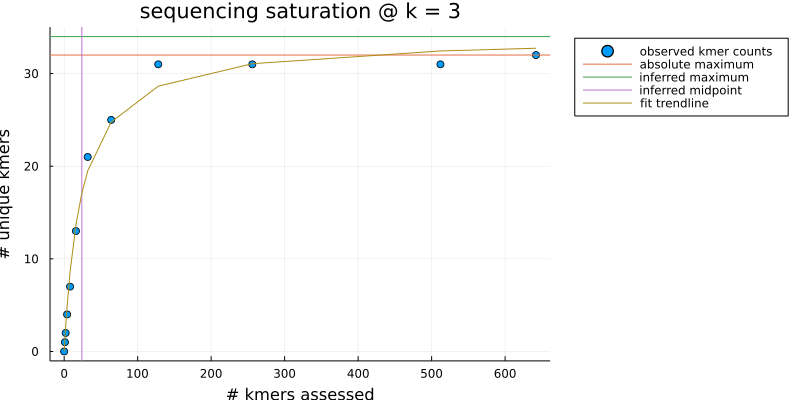

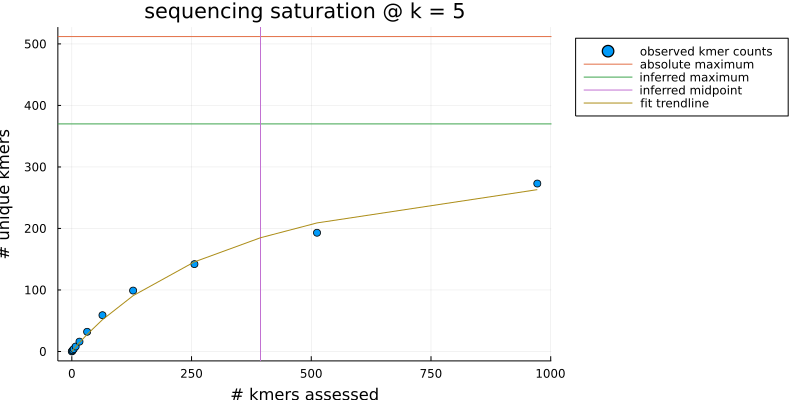

  0.000331 seconds (290 allocations: 37.203 KiB)
(k, predicted_saturation) = (3, 1.0625)
  0.000260 seconds (378 allocations: 48.641 KiB)
(k, predicted_saturation) = (5, 0.533203125)


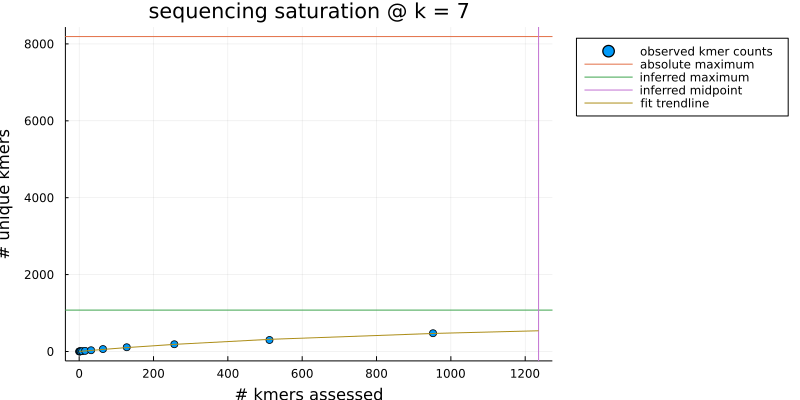

  0.000152 seconds (378 allocations: 48.641 KiB)
(k, predicted_saturation) = (7, 0.0579833984375)


In [147]:
ks = Primes.primes(3, 31)
# ks = Primes.primes(11, 31)
minimum_k = first(ks)
minimum_saturation = Inf
midpoint = Inf
for k in ks
    kmer_type = BioSequences.DNAMer{k}
    kmers_to_assess = 10_000_000
    sampling_points, kmer_counts, read_entire_file = assess_kmer_saturation(fastq_file, kmer_type, kmers_to_assess=kmers_to_assess, power=power)
#     observed_midpoint_index = findfirst(i -> kmer_counts[i] > last(kmer_counts)/2, 1:length(sampling_points))
#     observed_midpoint = sampling_points[observed_midpoint_index]
    initial_parameters = Float64[maximum(kmer_counts), 1.0]
    @time fit = LsqFit.curve_fit(calculate_v, sampling_points, kmer_counts, initial_parameters)
    inferred_kmer_count = Int(ceil(fit.param[1]))
    inferred_midpoint = Int(ceil(fit.param[2]))
    predicted_saturation = inferred_kmer_count / max_canonical_kmers(kmer_type)
    
    if read_entire_file
        predicted_saturation = last(kmer_counts)/max_canonical_kmers(kmer_type)
    end
    
    @show k, predicted_saturation
    
    p = StatsPlots.scatter(
        sampling_points,
        kmer_counts,
        label="observed kmer counts",
        ylabel="# unique kmers",
        xlabel="# kmers assessed",
        title = "sequencing saturation @ k = $k",
        legend=:outertopright,
        size=(800, 400)
        )
    StatsPlots.hline!(p, [max_canonical_kmers(kmer_type)], label="absolute maximum")
    StatsPlots.hline!(p, [inferred_kmer_count], label="inferred maximum")
    StatsPlots.vline!(p, [inferred_midpoint], label="inferred midpoint")
    xs = sort([sampling_points..., inferred_midpoint])
    ys = calculate_v(xs, fit.param)
    StatsPlots.plot!(
        p,
        xs,
        ys,
        label="fit trendline")
    display(p)
    
    if predicted_saturation < minimum_saturation
        minimum_saturation = predicted_saturation
        minimum_k = k
        midpoint = inferred_midpoint 
    end
    if predicted_saturation < 0.1
        break
    end
end

In [148]:
kmers_to_write = midpoint

1236

In [149]:
k = minimum_k

7

In [150]:
kmer_type = BioSequences.DNAMer{k}
# kmers_per_read = read_lengths .- k .+ 1
# total_kmers = sum(kmers_per_read)

BioSequences.DNAMer{7} (alias for BioSequences.Mer{BioSequences.DNAAlphabet{2}, 7})

In [ ]:
# plot kmer spectra frequency

In [155]:
# 691.364224 seconds
@time kmer_counts = Mycelia.count_canonical_kmers(kmer_type, fastq_file)

  0.601756 seconds (640.86 k allocations: 36.279 MiB, 82.44% compilation time)


OrderedCollections.OrderedDict{BioSequences.DNAMer{7}, Int64} with 475 entries:
  AAAAGCT => 1
  AAAATTC => 1
  AAAATTG => 1
  AAAATTT => 5
  AAACGGG => 1
  AAAGCGC => 1
  AAAGCTT => 1
  AAAGGAC => 1
  AAATAGA => 1
  AAATTCT => 1
  AAATTGC => 1
  AAATTTC => 1
  AAATTTG => 8
  AACAAAT => 1
  AACCCCC => 1
  AACCTCG => 2
  AACGGGA => 1
  AACTCCC => 6
  AACTGCC => 1
  AAGAAGC => 1
  AAGAATT => 1
  AAGATCG => 9
  AAGCAAA => 6
  AAGCAAG => 1
  AAGCAAT => 1
  ⋮       => ⋮

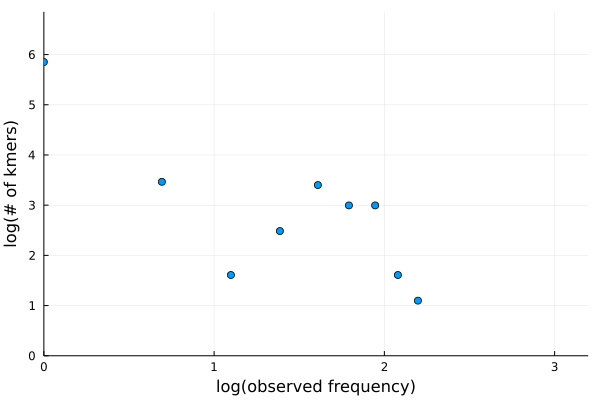

In [156]:
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts))

In [157]:
kmer_counts_histogram = StatsBase.countmap(values(kmer_counts))

Dict{Int64, Int64} with 9 entries:
  5 => 30
  4 => 12
  6 => 20
  7 => 20
  2 => 32
  9 => 3
  8 => 5
  3 => 5
  1 => 348

In [158]:
# n_partitions = 7
# partition_size = Int(ceil(length(sorted_kmer_count_bins) / n_partitions))

In [159]:
# for partition in Base.Iterators.partition(sorted_kmer_count_bins, partition_size)
# #     partition
#     @show partition
#     min_value, index = findmin(v -> kmer_counts_histogram[v], partition)
#     threshold = partition[index]
#     @show min_value, threshold
# end

In [160]:
# filtered_kmer_counts = filter(x -> x[2] >= assembly_threshold, kmer_counts)

In [161]:
K = length(keys(kmer_counts))

475

In [162]:
# create an undirected kmer graph from the sequence

In [163]:
graph = MetaGraphs.MetaGraph(K)
# graph = LightGraphs.SimpleGraph(K)

{475, 0} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [164]:
MetaGraphs.set_prop!(graph, :kmer_counts, kmer_counts)
MetaGraphs.set_prop!(graph, :k, k)

true

In [165]:
ProgressMeter.@showprogress for (i, (kmer, count)) in enumerate(kmer_counts)
#     @show i, kmer, count
    MetaGraphs.set_prop!(graph, i, :kmer, kmer)
    MetaGraphs.set_prop!(graph, i, :count, count)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [166]:
kmers = collect(keys(kmer_counts))

475-element Vector{BioSequences.DNAMer{7}}:
 AAAAGCT
 AAAATTC
 AAAATTG
 AAAATTT
 AAACGGG
 AAAGCGC
 AAAGCTT
 AAAGGAC
 AAATAGA
 AAATTCT
 AAATTGC
 AAATTTC
 AAATTTG
 ⋮
 TCTACCA
 TCTAGCA
 TCTCCCA
 TCTGCAA
 TCTTCCA
 TGACACA
 TGACTCA
 TGAGTAA
 TGATCAA
 TGGTCAA
 TGTCAAA
 TTGACAA

In [167]:
# p = ProgressMeter.Progress(8452, 1)
# 50 minutes
# 40 minutes
# 0:09:51!
for record in Mycelia.open_fastx(fastq_file)
    for edge_mer in BioSequences.each(BioSequences.DNAMer{k+1}, FASTX.sequence(record))
        add_edge_to_graph(graph, edge_mer, kmers)
    end
#     ProgressMeter.next!(p)
end

In [168]:
observations = collect(Mycelia.open_fastx(fastq_file));

In [1462]:
observation = observations[10];

In [1463]:
observed_sequence = FASTX.sequence(observation);

In [1464]:
alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), observed_sequence, genome);

In [1465]:
reverse_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(observed_sequence), genome);

In [1466]:
if reverse_alignment.value < alignment.value
    observed_sequence = observed_sequence
    alignment = reverse_alignment
    @show "flipping"
end
@show alignment.value

alignment.value = 15


15

In [1566]:
-11 - 15 - 17

-43

In [1551]:
# -15/100
# 0/100
# -17/100
# 2/100
# 1/100
# 0/100
# 3/100
# 2/100
# 1/100
# -3/100
# -26
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/v]

# -11/100
# 0/100
# 0/100
# -15/100
# 0/100
# 1/100
# 0/100
# 0/100
# -17/100
# -1/100
# -43
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(2^v)]

# 2/100
# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# 2
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(MathConstants.e^(v))]

# 0/100
# 0/100
# 0/100
# 0/100
# 0/100
# -1/100
# 0/100
# 0/100
# 0/100
# 0/100
# -1
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(10^(v))]

# 3/100
# -4/100
# 10/100
# 4/100
# 3/100
# 1/100
# 1/100
# -24/100
# -16/100
# 2/100
# -19
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(2^(v-1))]

# -33/100
# 2/100
# 3/100
# -3/100
# 3/100
# 1/100
# -3/100
# 4/100
# -1/100
# -7/100
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(MathConstants.e^(v-1))]

# 2/100
# 3/100
# 1/100
# 2/100
# -6/100
# -3/100
# -1/100
# 0/100
# 0/100
# -1/100
# @time indices_to_keep = [i for (i,v) in enumerate(values(kmer_counts)) if rand() > 1/(10^(v-1))]

  0.110353 seconds (80.42 k allocations: 4.639 MiB, 96.84% compilation time)


124-element Vector{Int64}:
   4
  13
  16
  18
  22
  23
  27
  32
  35
  38
  41
  48
  49
   ⋮
 442
 446
 454
 455
 456
 457
 458
 462
 464
 467
 470
 472

In [1552]:
# ?LightGraphs.induced_subgraph
subgraph, vertex_map = LightGraphs.induced_subgraph(graph, indices_to_keep)

({124, 126} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [4, 13, 16, 18, 22, 23, 27, 32, 35, 38  …  454, 455, 456, 457, 458, 462, 464, 467, 470, 472])

In [1553]:
# function sequence_to_
observation_as_oriented_kmers = []
observation_kmers = collect(BioSequences.each(BioSequences.DNAMer{k}, observed_sequence))

95-element Vector{BioSequences.MerIterResult{BioSequences.DNAMer{7}}}:
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(1, TTTGACC, GGTCAAA)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(2, TTGACCA, TGGTCAA)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(3, TGACCAC, GTGGTCA)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(4, GACCACA, TGTGGTC)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(5, ACCACAG, CTGTGGT)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(6, CCACAGA, TCTGTGG)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(7, CACAGAG, CTCTGTG)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(8, ACAGAGG, CCTCTGT)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(9, CAGAGGA, TCCTCTG)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(10, AGAGGAG, CTCCTCT)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(11, GAGGAGG, CCTCCTC)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}}(12, AGGAGGC, GCCTCCT)
 BioSequences.MerIterResult{BioSequences.DNAMer{7}

In [1554]:
subgraph_kmers = [subgraph.vprops[v][:kmer] for v in LightGraphs.vertices(subgraph)]

124-element Vector{BioSequences.DNAMer{7}}:
 AAAATTT
 AAATTTG
 AACCTCG
 AACTCCC
 AAGATCG
 AAGCAAA
 AAGCGCA
 AAGGAGA
 AAGGGAG
 AAGTGCG
 AATAGAA
 AATTTGC
 AATTTGT
 ⋮
 GTGGTCA
 TACCACA
 TCACAGA
 TCCACAA
 TCCACGA
 TCCGCGA
 TCCTCCA
 TCGCGAA
 TCTACCA
 TCTGCAA
 TGACTCA
 TGATCAA

In [1555]:
is_canonical = falses(length(observation_kmers))
kmer_index = zeros(Int, length(observation_kmers))
for (i, kmer) in enumerate(observation_kmers)
#     is_canonical[i] = kmer.fw <= kmer.bw
    canonical_kmer = BioSequences.canonical(kmer.fw)
    is_canonical[i] = kmer.fw == canonical_kmer
    kmer_index_range = searchsorted(subgraph_kmers, canonical_kmer)
    if length(kmer_index_range) > 1
        @error "bad"
    elseif isempty(kmer_index_range)
        # do nothing, index is 0 to indicate not found
    else
        kmer_index[i] = first(kmer_index_range)
    end
end

In [1556]:
is_canonical

95-element BitVector:
 0
 0
 0
 1
 1
 1
 1
 1
 1
 1
 0
 1
 0
 ⋮
 0
 0
 1
 1
 1
 0
 0
 0
 0
 0
 0
 0

In [1557]:
kmer_index

95-element Vector{Int64}:
   0
   0
 113
  97
   0
   0
   0
   0
   0
  30
  67
  40
  36
   ⋮
  12
   2
   2
  13
   0
  60
  18
 114
  79
 121
  48
  59

In [1558]:
proposed_path = BioSequences.DNAMer{k}[]
opening_missing_kmer_path_index = findfirst(x -> x == 0, kmer_index)

# read is solid!
if opening_missing_kmer_path_index == nothing
#     proposed_seq = observation
    proposed_path = [kmer.fw for kmer in observation_kmers]
    @show "perfect read"
elseif all(index -> index == 0, kmer_index)
    @show "read is trash"
    # generate a new read from the assembly to replace this one

    observation_path_length = length(observation_kmers)
    proposed_path = nothing
    proposed_path_size_discrepancy = Inf
    starting_kmer_indices = StatsBase.sample(1:LightGraphs.nv(graph), min(10, LightGraphs.nv(graph)), replace=false)
    for starting_kmer_index in starting_kmer_indices
        starting_kmer_index = rand(1:LightGraphs.nv(graph))
        @show starting_kmer_index
        starting_kmer = graph.vprops[starting_kmer_index][:kmer]
        if rand(Bool)
            starting_kmer = BioSequences.reverse_complement(starting_kmer)
        end
#         candidate_path = take_a_walk(graph, edge_likelihoods, kmers, starting_kmer, observation_path_length)
        candidate_path = take_a_walk(graph, kmers, starting_kmer, observation_path_length)
        discrepancy = abs(length(candidate_path) - observation_path_length)
        @show discrepancy
        if discrepancy < proposed_path_size_discrepancy
            proposed_path = candidate_path
            proposed_path_size_discrepancy = discrepancy
            if proposed_path_size_discrepancy == 0
                break
            end
        end
    end
else
    if opening_missing_kmer_path_index == 1
        opening_solid_kmer = nothing
    #     closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    elseif opening_missing_kmer_path_index != nothing
        opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
        opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
    end

    if opening_missing_kmer_path_index == nothing
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), 1)
    else
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    end
    if closing_solid_kmer_path_index == nothing
        @show "end is open"
        closing_solid_kmer = nothing
    else
        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
    end


    extensions = 0
    while (opening_missing_kmer_path_index != nothing) && (extensions < 5)
        extensions += 1
        @show extensions

        if (opening_solid_kmer == nothing) && (closing_solid_kmer != nothing)
            @show "missing opening"
            @show closing_solid_kmer
            inverted_closing_solid_kmer = BioSequences.reverse_complement(closing_solid_kmer)
            @show inverted_closing_solid_kmer
            walk_length = closing_solid_kmer_path_index
#             chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, inverted_closing_solid_kmer, walk_length)
            chosen_walk = take_a_walk(graph, kmers, inverted_closing_solid_kmer, walk_length)
            chosen_walk = reverse(BioSequences.reverse_complement.(chosen_walk))
            @show chosen_walk
            @show closing_solid_kmer_path_index
            @assert observation_kmers[closing_solid_kmer_path_index].fw == last(chosen_walk)
            proposed_path = chosen_walk
            opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)

            if opening_missing_kmer_path_index == 1
                opening_solid_kmer = nothing
            elseif opening_missing_kmer_path_index != nothing
                need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                append!(proposed_path, need_to_add)
                opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                if closing_solid_kmer_path_index == nothing
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end

        if (opening_solid_kmer != nothing) && (closing_solid_kmer == nothing)
            @show "missing closing"
            walk_length = length(observation_kmers) - opening_solid_kmer_path_index+1
#             chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)
            chosen_walk = take_a_walk(graph, kmers, opening_solid_kmer, walk_length)
            @show chosen_walk
            @assert observation_kmers[opening_solid_kmer_path_index].fw == first(chosen_walk)
            if isempty(proposed_path)
                proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
            end
            append!(proposed_path, chosen_walk[2:end])
            opening_missing_kmer_path_index = nothing
        end

        while (opening_solid_kmer != nothing) && (closing_solid_kmer != nothing)
            @show "bubble!"
            opening_solid_kmer_index = kmer_index[opening_solid_kmer_path_index]
            closing_solid_kmer_index = kmer_index[closing_solid_kmer_path_index]

            @show opening_solid_kmer, opening_solid_kmer_path_index
            @show closing_solid_kmer, closing_solid_kmer_path_index
            @show length(proposed_path)
            
            #####################################################################################
            # DETERMINE PATH LENGTH
            #####################################################################################
            # by default, we're assuming that we want to walk the same distance as our bubble + 1
            bubble_path_length = closing_solid_kmer_path_index - opening_solid_kmer_path_index + 1

            if opening_solid_kmer_index != closing_solid_kmer_index
                path = LightGraphs.a_star(graph, opening_solid_kmer_index, closing_solid_kmer_index)
                normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                shortest_paths = [normalized_path]
            else
                neighbors = LightGraphs.neighbors(graph, opening_solid_kmer_index)
                shortest_paths = Vector{Vector{Int}}()
                for neighbor in neighbors
                    path = LightGraphs.a_star(graph, neighbor, closing_solid_kmer_index)
                    normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                    push!(shortest_paths, normalized_path)
                end
            end
            # but if our bubble is a deletion, then walking that length may not get us across to the other side
            # so we also determine the longest, shortest path
            longest_shortest_walk_length = maximum(length.(shortest_paths))


            longest_walk_length = max(bubble_path_length, longest_shortest_walk_length)
            walk_length = Int(ceil(longest_walk_length * 1.1))

            walks = Vector{Int}[]
            for i in 1:3
                println("round $i")
#                 walks = [take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)]
                walks = [take_a_walk(graph, kmers, opening_solid_kmer, walk_length)]
                while allunique(walks)
#                     push!(walks, take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length))
                    push!(walks, take_a_walk(graph, kmers, opening_solid_kmer, walk_length))
                end

                walks = filter(path -> closing_solid_kmer in path, walks)

                if isempty(walks)
                    walk_length = Int(ceil(walk_length * 1.1))
                else
                    # done!
                    break
                end
            end

            if !isempty(walks)
                candidate_paths = sort(collect(StatsBase.countmap(walks)), by=x->x[2], rev=true)
                selected_path = first(first(candidate_paths))
                selected_path_closing_solid_kmer_intersects = findall(kmer -> kmer == closing_solid_kmer, selected_path)
                if length(selected_path_closing_solid_kmer_intersects) > 1
                    @show "here"
                    selected_path_closing_solid_kmer_intersect = 0
                    d = Inf
                    for i in selected_path_closing_solid_kmer_intersects
                        candidate_distance = abs(i - walk_length)
                        if candidate_distance < d
                            d = candidate_distance
                            selected_path_closing_solid_kmer_intersect = i
                        end
                    end
                else
                    selected_path_closing_solid_kmer_intersect = first(selected_path_closing_solid_kmer_intersects)
                end
                selected_path = selected_path[1:selected_path_closing_solid_kmer_intersect]
                if isempty(proposed_path)
                    proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
                end
                append!(proposed_path, selected_path[2:end])
                opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)
                if opening_missing_kmer_path_index == nothing
                    #done
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index == 1
                    # also done?
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index != nothing
                    need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                    append!(proposed_path, need_to_add)
                    opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                    opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                    closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                    if closing_solid_kmer_path_index == nothing
                        closing_solid_kmer = nothing
                    else
                        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                    end
                end
            else
                @show "need to bump out"
                if opening_missing_kmer_path_index >= 2
                    opening_missing_kmer_path_index -= 1
                    opening_solid_kmer = nothing
                    # this should now break out to larger while loop
                end
                # push out closing node and try again
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), closing_solid_kmer_path_index+1)

                if closing_solid_kmer_path_index == nothing
                    @show "end is open"
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end
    end
    if closing_solid_kmer_path_index != nothing
        append!(proposed_path, getproperty.(observation_kmers[closing_solid_kmer_path_index+1:end], :fw))
    end
end

extensions = 1
"missing opening" = "missing opening"
closing_solid_kmer = TGACCAC
inverted_closing_solid_kmer = GTGGTCA
chosen_walk = BioSequences.DNAMer{7}[TTTGACC, TTGACCA, TGACCAC]
closing_solid_kmer_path_index = 3
"bubble!" = "bubble!"
(opening_solid_kmer, opening_solid_kmer_path_index) = (GACCACA, 4)
(closing_solid_kmer, closing_solid_kmer_path_index) = (AGAGGAG, 10)
length(proposed_path) = 4
round 1
"bubble!" = "bubble!"
(opening_solid_kmer, opening_solid_kmer_path_index) = (GGAGGCT, 13)
(closing_solid_kmer, closing_solid_kmer_path_index) = (ACGTCGT, 23)
length(proposed_path) = 13
round 1
"bubble!" = "bubble!"
(opening_solid_kmer, opening_solid_kmer_path_index) = (CGTGGAG, 27)
(closing_solid_kmer, closing_solid_kmer_path_index) = (GAGAGAG, 31)
length(proposed_path) = 27
round 1
round 2
"here" = "here"
"bubble!" = "bubble!"
(opening_solid_kmer, opening_solid_kmer_path_index) = (GAGAGAG, 35)
(closing_solid_kmer, closing_solid_kmer_path_index) = (GTTGCAG, 45)
length(proposed_path) =

97-element Vector{BioSequences.DNAMer{7}}:
 TTTGACC
 TTGACCA
 TGACCAC
 GACCACA
 ACCACAG
 CCACAGA
 CACAGAG
 ACAGAGG
 CAGAGGA
 AGAGGAG
 GAGGAGG
 AGGAGGC
 GGAGGCT
 ⋮
 GCAAATT
 CAAATTT
 AAATTTG
 AATTTGT
 ATTTGTG
 TTTGTGG
 TTGTGGT
 TGTGGTA
 GTGGTAG
 TGGTAGA
 GGTAGAT
 GTAGATG

In [1559]:
proposed_path

97-element Vector{BioSequences.DNAMer{7}}:
 TTTGACC
 TTGACCA
 TGACCAC
 GACCACA
 ACCACAG
 CCACAGA
 CACAGAG
 ACAGAGG
 CAGAGGA
 AGAGGAG
 GAGGAGG
 AGGAGGC
 GGAGGCT
 ⋮
 GCAAATT
 CAAATTT
 AAATTTG
 AATTTGT
 ATTTGTG
 TTTGTGG
 TTGTGGT
 TGTGGTA
 GTGGTAG
 TGGTAGA
 GGTAGAT
 GTAGATG

In [1560]:
proposed_seq = BioSequences.LongDNASeq(first(proposed_path))
for kmer in proposed_path[2:end]
    push!(proposed_seq, last(kmer))
end
proposed_seq

103nt DNA Sequence:
TTTGACCACAGAGGAGGCTTACACGTCGTGGAGAGAGAG…TATTCCGCGGAAGATCGCGAAGCAAATTTGTGGTAGATG

In [1561]:
new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), proposed_seq, genome)

BioAlignments.PairwiseAlignmentResult{Int64, BioSequences.LongDNASeq, BioSequences.LongDNASeq}:
  distance: 16
  seq:   1 TTTGAC-CACAG-AGGAG-GCTTACACGTCGTGGAGAGAGAGAGAGGGGGTTGCAGACAG  57
           |||||| ||||| ||||| || ||| | |||||||| | |||| |||| ||||||||  |
  ref:   1 TTTGACTCACAGAAGGAGAGCCTAC-C-TCGTGGAG-G-GAGA-AGGGAGTTGCAGAGTG  55

  seq:  58 CGCGCTCTATTCCGCGGAAGATCGCGAAGCAAA-TTTGTGGTAGATG 103
           |||  |||||| ||||||||||||||||||||| |||||||||||||
  ref:  56 CGC-TTCTATT-CGCGGAAGATCGCGAAGCAAATTTTGTGGTAGATG 100


In [1562]:
reverse_new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(proposed_seq), genome)

BioAlignments.PairwiseAlignmentResult{Int64, BioSequences.LongDNASeq, BioSequences.LongDNASeq}:
  distance: 51
  seq:   1 CATCTAC-CACA-AATTTGCTTCGCGATCTTCCGCGGA-ATAG-AGCGCGCTGTCTGCAA  56
             |  || |||| ||   |   | | | | | || |||   || || | | || | | | 
  ref:   0 -TTTGACTCACAGAAGGAG-AGC-CTA-CCT-CGTGGAGGGAGAAGGGAGTTG-CAG-AG  53

  seq:  57 CCCCCTCTCTCTCTCTC-CACGA-CGTGTAAGCCTCCTCTGTGGT-CAAA 103
             | || ||| | || |  | || || | ||||    | ||||||  |  
  ref:  54 TGCGCT-TCTAT-TCGCGGAAGATCGCG-AAGCAAATTTTGTGGTAGATG 100


In [1563]:
if reverse_new_alignment.value < new_alignment.value
#     observation = BioSequences.reverse_complement!(observation)
    new_alignment = reverse_new_alignment
    @show "flipping"
end

In [1564]:
if new_alignment.value <= alignment.value
    @show "newer is equivalent or better"
    @show new_alignment.value, alignment.value
    println(alignment.value - new_alignment.value,'/',length(genome))
else
    @show "newer is worse, keep original"
    @show new_alignment.value, alignment.value
    println(alignment.value - new_alignment.value,'/',length(genome))
#     @show alignment.value - new_alignment.value, length(genome) 
end

"newer is worse, keep original" = "newer is worse, keep original"
(new_alignment.value, alignment.value) = (16, 15)
-1/100


In [ ]:
# outcome
# resampling with probability 1/(2^(count-1)) seems like a good approach!
# sometimes we really botch the outcomes, so don't always accept
# also, we can't use alignment against reference in cases where we don't have a reference
# use joint probabilities of all vertices * length of sequence to get sequence likelihood

In [1620]:
probabilities = [rand() for i in 1:rand(1:10)]

4-element Vector{Float64}:
 0.8754820640153844
 0.006895361784062581
 0.22447251989607886
 0.6750403927765825

In [1621]:
reduce(*, probabilities) * length(probabilities)

0.003658956485854512

In [1622]:
probabilities[rand(1:length(probabilities))] = .99
reduce(*, probabilities) * length(probabilities)

0.005366148396092882

In [1569]:
# StatsBase.summarystats(collect(values(kmer_counts)))

Summary Stats:
Length:         475
Missing Count:  0
Mean:           2.004211
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   2.000000
Maximum:        9.000000
